In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json|

Saving kaggle.json to kaggle.json
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [3]:
!kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

 99% 1.13G/1.14G [00:16<00:00, 97.9MB/s]
100% 1.14G/1.14G [00:16<00:00, 73.3MB/s]


In [4]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [7]:
batch_size = 32

img_height = 150
img_width = 150

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rescale=1./255,zoom_range=0.4,shear_range=0.3,vertical_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

In [9]:
train = image_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size)
test = test_data_gen.flow_from_directory(test_path,target_size=(img_height,img_width),shuffle=False,class_mode='binary',color_mode='grayscale',batch_size=batch_size)
valid = test_data_gen.flow_from_directory(valid_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size)

decoder_input = test_data_gen.flow_from_directory(train_path,target_size=(img_height,img_width),class_mode='binary',color_mode='grayscale',batch_size=batch_size,shuffle=False)
decoder_output = test_data_gen.flow_from_directory(train_path,target_size=(150,150),class_mode='binary',color_mode='grayscale',batch_size=batch_size,shuffle=False)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 4192 images belonging to 2 classes.
Found 4192 images belonging to 2 classes.


In [10]:
import tensorflow as tf
import os
import keras
from keras.models import Sequential, Model
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, BatchNormalization, Input, SeparableConv2D, UpSampling2D, ZeroPadding2D

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tqdm.notebook import tqdm

from keras.optimizers import SGD
from keras.layers.merge import concatenate

In [11]:
#Creating the decoder's data
X = []
Y = []
for _ in tqdm(range(131)):
    X += list(decoder_input.next()[0])
    Y += list(decoder_output.next()[0])
X = np.array(X)
Y = np.array(Y)

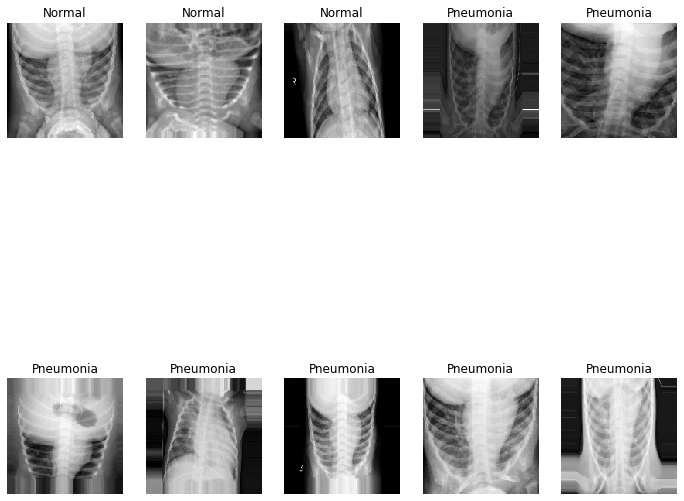

In [12]:
plt.figure(figsize=(12,12))
for i in range(0,10):
  plt.subplot(2,5,i+1)
  for X_batch,Y_batch in train:
    image = X_batch[0]
    dic = {0:'Normal',1:'Pneumonia'}
    plt.title(dic.get(Y_batch[0]))
    plt.axis('off')

    plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
    break

    plt.tight_layout()
    plt.show()

In [13]:
#Densenet Functions


def InceptionBlock(inputs, num_filters):
    #Pipe1
    pipe1 = SeparableConv2D(num_filters,kernel_size=(1,1),padding='same', activation='relu')(inputs)
    pipe1 = SeparableConv2D(num_filters,kernel_size=(5,5), padding='same', activation='relu')(pipe1)
    
    #Pipe2
    pipe2 = SeparableConv2D(num_filters,kernel_size=(1,1), padding='same', activation='relu')(inputs)
    pipe2 = SeparableConv2D(num_filters,kernel_size=(3,3), padding='same', activation='relu')(pipe2)
    
    #Pipe3
    pipe3 = MaxPooling2D((3,3),strides=(1,1),padding='same')(inputs)
    pipe3 = SeparableConv2D(num_filters,kernel_size=(1,1), padding='same', activation='relu')(pipe3)
    
    #Pipe4
    pipe4 = SeparableConv2D(num_filters,kernel_size=(1,1), padding='same', activation='relu')(inputs)
    
    #Output
    output = concatenate([pipe4,pipe2,pipe1,], axis=-1)
    
    return output

In [14]:
input_layer = Input(shape=(img_height,img_width,1))

#Encoder

enc = InceptionBlock(input_layer,32)
enc = InceptionBlock(enc,64)
enc = InceptionBlock(enc,98)


Encoder = Model(input_layer,enc)

#Decoder

decoder = SeparableConv2D(128, (3, 3), activation='sigmoid', padding='same')(enc)
decoder = BatchNormalization()(decoder)
decoder = SeparableConv2D(128, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)

decoder = SeparableConv2D(64, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = SeparableConv2D(64, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)

decoder = SeparableConv2D(32, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = SeparableConv2D(32, (3, 3), activation='sigmoid', padding='same')(decoder)
decoder = BatchNormalization()(decoder)


decoder = SeparableConv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

Decoder = Model(input_layer,decoder)
                
                
#Classifier
flatten = Flatten()(enc)
dense = Dense(64,activation='relu')(flatten)
dense = BatchNormalization()(dense)
dense = Dropout(0.5)(dense)
dense = Dense(1,activation='sigmoid')(dense)

Classifier = Model(input_layer,dense)

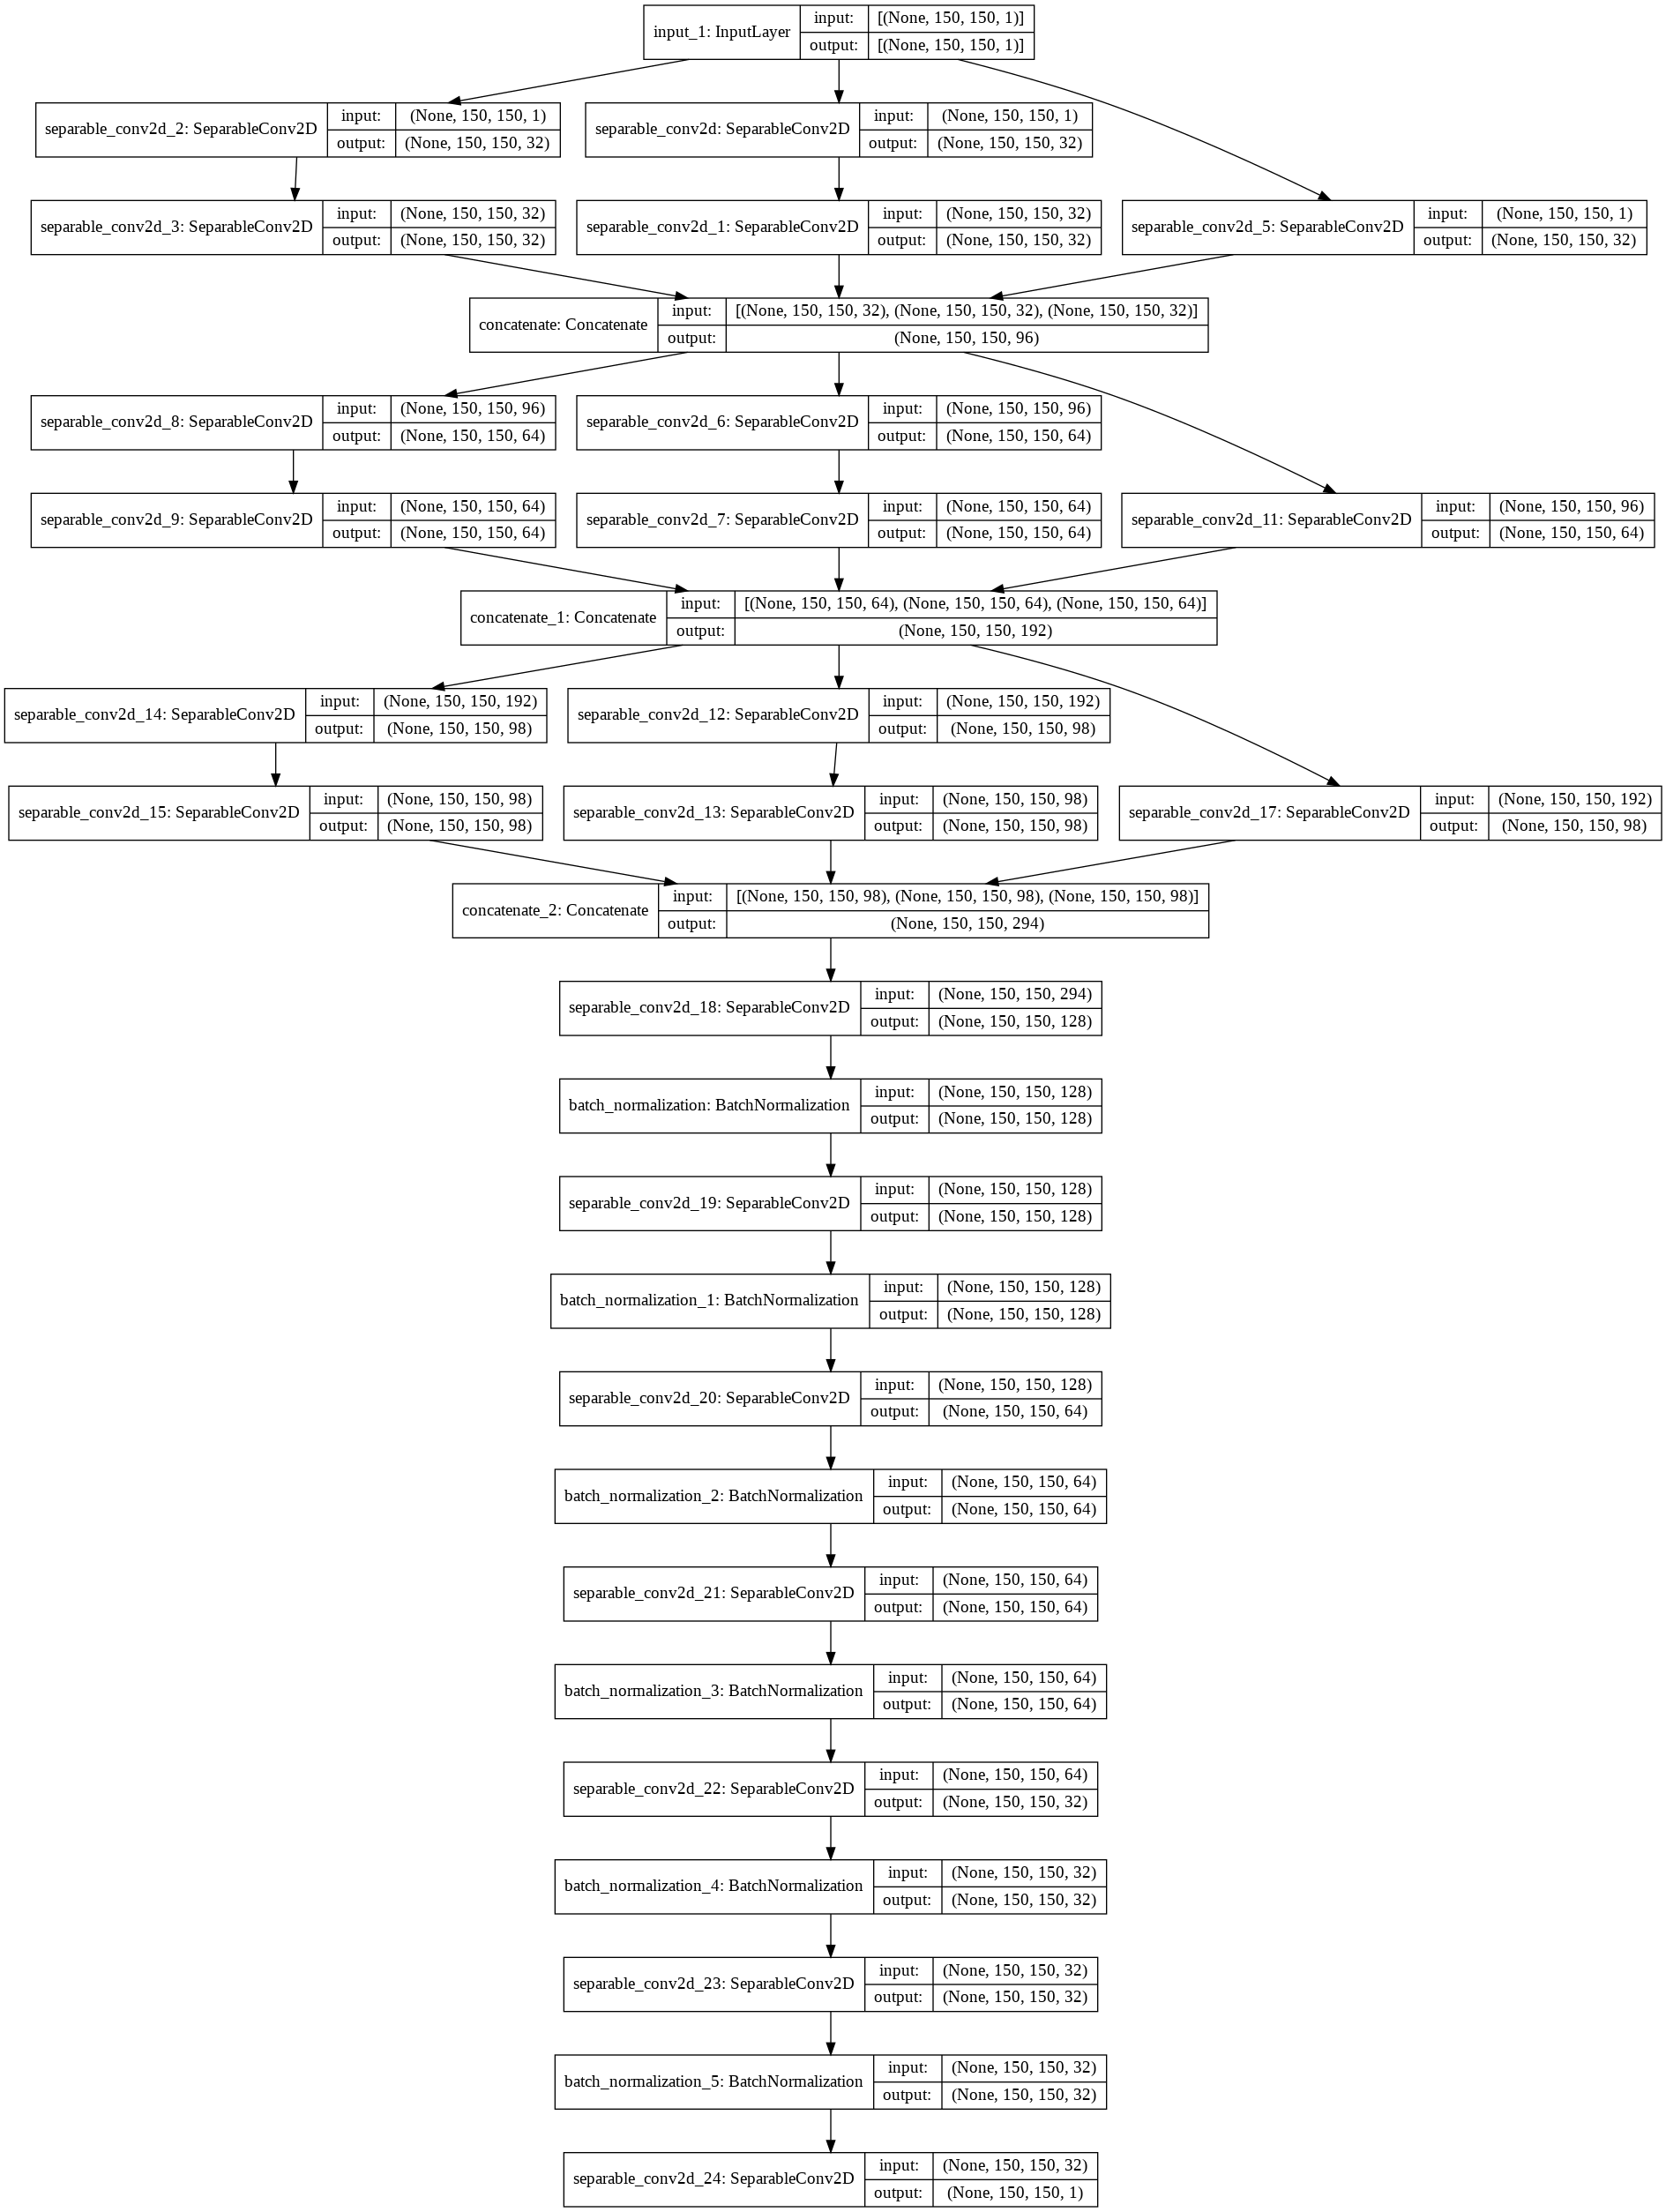

In [15]:
from keras.utils import plot_model
plot_model(Decoder,show_shapes=True, show_layer_names=True)

In [16]:
Decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
separable_conv2d_2 (SeparableCo (None, 150, 150, 32) 65          input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 150, 150, 32) 65          input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_5 (SeparableCo (None, 150, 150, 32) 65          input_1[0][0]                    
____________________________________________________________________________________________

In [17]:
Decoder.compile(loss='mean_squared_error', optimizer = SGD())

In [ ]:
Decoder.fit(X,Y,batch_size=batch_size,epochs=30)

Epoch 1/30


In [ ]:
predictions = Decoder.predict(X)

In [ ]:
plt.imshow((tf.squeeze(predictions[0])))
plt.show()

In [ ]:
plt.imshow((tf.squeeze(X[0])))
plt.show()

In [ ]:
plt.imshow((tf.squeeze(Y[0])))
plt.show()

In [ ]:
Classifier.summary()

In [ ]:
Classifier.compile(optimizer=SGD(),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes),train.classes)
cw = dict(zip(np.unique(train.classes),weights))
print(cw)

In [ ]:
Classifier.fit(train,epochs=25,validation_data=valid,class_weight=cw,batch_size=512)

In [ ]:
pd.DataFrame(Classifier.history.history).plot()

In [ ]:
test_accu = Classifier.evaluate(test)
print('The testing accuracy is - ',test_accu[1]*100,'%')

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

In [ ]:
y_bar = np.round(Classifier.predict(test)).reshape(-1)
y_act = test.labels

In [ ]:
##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##Roc_Auc Score
print("ROC-AUC score: ",roc_auc_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act))
##Log Loss Score
print("Log Loss: ",log_loss(y_bar,y_act))

In [ ]:
Classifier.save('custom_cnn.h5')